In [1]:
import qiskit

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

In [3]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries, MatrixOp
from qiskit import IBMQ, BasicAer, Aer
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                  WeightedPauliOperator,
                                  MatrixOperator)
import warnings
import time

In [4]:
start_time = time.time()
warnings.filterwarnings("ignore")
file_path = fr'./Hdarkenergyosc64x64.txt'
H_file = np.loadtxt(file_path)

HH = MatrixOp(primitive=H_file)
HHH = HH.to_pauli_op()
qubitOp = HHH.to_legacy_op()

print("Size of Hamiltonian:", np.shape(H_file))
print(qubitOp)
print(qubitOp.print_details())
type(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:', runtime)

Size of Hamiltonian: (64, 64)
Representation: paulis, qubits: 6, size: 1319
IIIIII	(144.1482666461244+0j)
IIIIIX	(-106.79800076476529+0j)
IIIIXI	(55.52817108651396+0j)
IIIIXX	(-67.49657749765441+0j)
IIIIXZ	(-0.3727772525539379+0j)
IIIIYY	(-41.22765328061329+0j)
IIIIZI	(-1.6219525995202417+0j)
IIIIZX	(1.5280181911227118+0j)
IIIIZZ	(-2.331656498537363+0j)
IIIXII	(8.335663949038715+0j)
IIIXIX	(-14.3875552826491+0j)
IIIXIZ	(-0.1659850692092919+0j)
IIIXXI	(28.389029842635615+0j)
IIIXXX	(-34.50068325034667+0j)
IIIXXZ	(-0.5877642695071144+0j)
IIIXYY	(20.10271464426032+0j)
IIIXZI	(-0.3817955970541318+0j)
IIIXZX	(0.6529839640083903+0j)
IIIXZZ	(-0.04532033857279427+0j)
IIIYIY	(-12.281897150691844+0j)
IIIYXY	(-21.123194050873863+0j)
IIIYYI	(27.93929719176093+0j)
IIIYYX	(-33.39750145917266+0j)
IIIYYZ	(-0.5763427941293733+0j)
IIIYZY	(0.5487142749286544+0j)
IIIZII	(-6.412416665392721+0j)
IIIZIX	(5.405619139857892+0j)
IIIZIZ	(-2.348504852933962+0j)
IIIZXI	(-3.763169607602882+0j)
IIIZXX	(4.64765428373

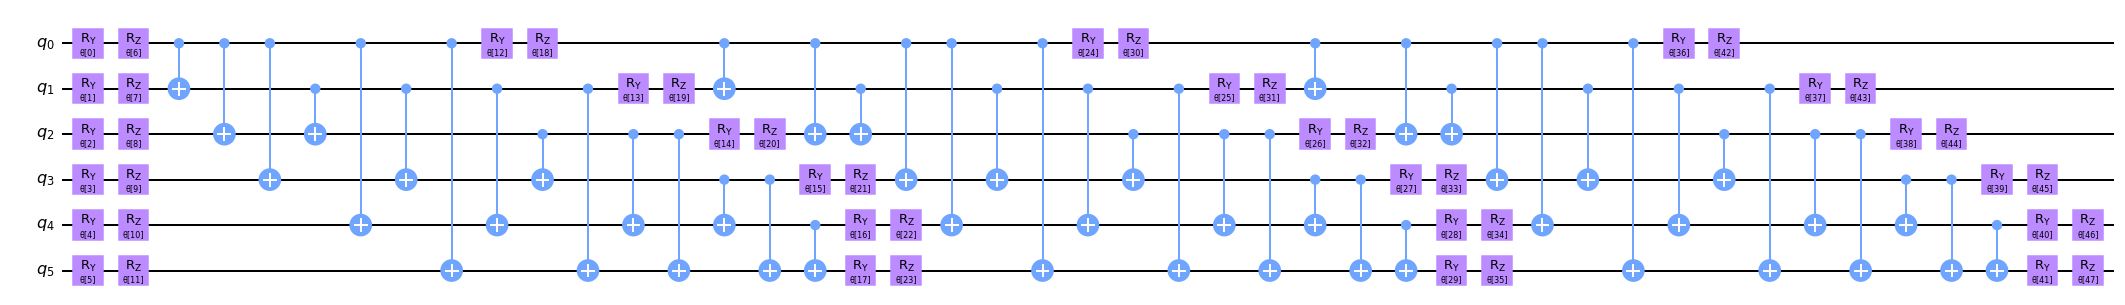

In [5]:
var_form = EfficientSU2(qubitOp.num_qubits,su2_gates=['ry','rz'],entanglement='full',reps=3)

display(var_form.draw(output='mpl',fold=100))

In [6]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [1.11710242e-06]


In [12]:
start_time = time.time()
warnings.filterwarnings("ignore")

backend = BasicAer.get_backend("statevector_simulator")
optimizer = SLSQP(maxiter=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

ret = vqe.run(backend)

vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:', runtime, "s")

VQE Result: 0.009163976619088191
Program runtime: 206.67082357406616 s


Text(4000, 5, 'Exact Result')

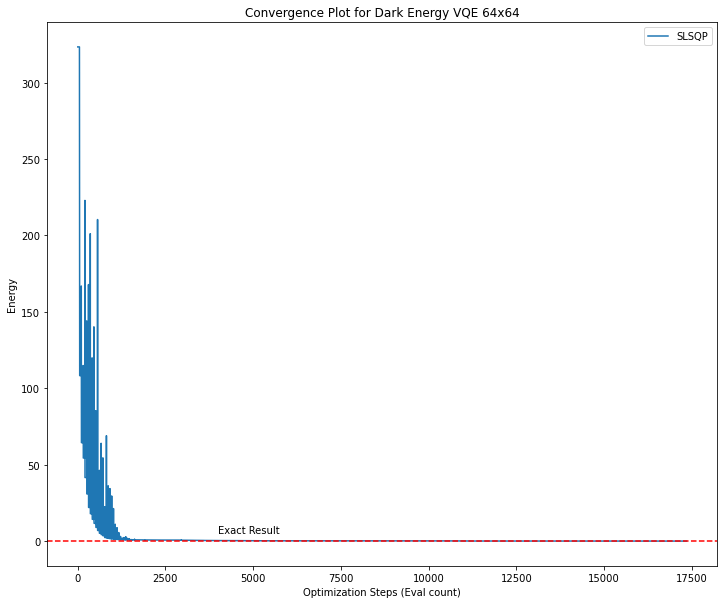

In [13]:
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Optimization Steps (Eval count)')
plt.ylabel('Energy')
plt.title('Convergence Plot for Dark Energy VQE 64x64')
plt.legend(loc='upper right')
plt.axhline(np.real(exact_solution.eigenvalues), color='red', linestyle='--')
plt.text(4000, 5, 'Exact Result')